
# Analyzing ESG report using Natural Language Processing, Topic Modeling and Text Classification of Sentences using the ESG-BERT Models 

## Summary
Environment, Social, and Governance (ESG) is a framework used to evaluate a company's sustainability and social impact. By assessing a company's performance in these three areas, investors can better understand potential risks and opportunities. ESG report gives an outlook to understand the non-financial performance of a company.

This analysis leverages Natural Language Processing (NLP) techniques, including ESGBERT, a specialized language model for ESG text classification, to extract key information from an ESG report (Pecan Energies 2023). ESGBERT was used to categorize sentences within the report into one of the three ESG dimensions: Environmental, Social, or Governance. I also then visualized the extracted data using Word Clouds and Topic Modeling (LDA) to identify the company's primary ESG trend and focus.

While this analysis provides a valuable starting point, it's important to note that ESG is a complex and multifaceted issue. 
Text classification can be improved in the further by identifying sentences with multilabels and irrelevant sentences to the ESG dimension. Different companies prioritize different aspects of ESG based on their industry, size, and geographic location.
This is to demonstrate my understanding and application of the theoricatical knowledge from the NLP class in ETSU CSCI 5037



## Install Dependencies

In [1]:
# !pip install PyPDF2
# !pip install gensim
# !pip install nltk
# !pip install WordCloud
# !pip install pdfminer3
# !pip install mlflow
# !pip3 install spacy
# !pip3 install pyLDAvis==2.1.2

In [2]:
# !pip freeze

---
## Import Libraries

In [3]:
# Standard libraries
import sys  
import re
import string
import warnings
import io
import os
import json
from pprint import pprint

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import pyLDAvis
import pyLDAvis.gensim

# NLP and Machine Learning
import spacy
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# PDF text extraction
from pdfminer3.layout import LAParams, LTTextBox
from pdfminer3.pdfpage import PDFPage
from pdfminer3.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer3.converter import PDFPageAggregator, TextConverter

# Miscellaneous tools
import requests
from tqdm.notebook import tqdm

# Custom modules (assumed to be in the '../src' directory)
sys.path.append('../src') 


# Set global configurations and options
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 50)

plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':60})
plt.style.use('fivethirtyeight')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




<frozen importlib._bootstrap>:488: DeprecationWarning: Type google._upb._message.MessageMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.
<frozen importlib._bootstrap>:488: DeprecationWarning: Type google._upb._message.ScalarMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.


In [4]:
def createfolder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)  

Create Folders to access reports


In [5]:
DATA_FOLDER = '../data/'
PDF_FOLDER = '../pdf/'
createfolder(DATA_FOLDER)
createfolder(PDF_FOLDER)

### Loading Language Model

In [6]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

import spacy
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm", disable=['ner'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aswad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aswad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Preparing Stop Words

In [7]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from sklearn.feature_extraction import text
stop_words = text.ENGLISH_STOP_WORDS.union(stop_words)

In [8]:
', '.join(stop_words)

"fifty, her, while, had, sincere, describe, just, sometime, side, us, less, why, throughout, before, meanwhile, therein, besides, could, whereby, doesn't, show, hence, any, neither, it, weren't, same, anyone, without, its, moreover, once, becomes, both, perhaps, many, inc, towards, became, s, de, needn't, hundred, yours, con, fill, that, somewhere, me, four, hadn, now, what, only, thereby, un, whoever, even, not, thus, there, hereupon, put, among, least, must, ten, shan't, whether, within, hers, they, from, bottom, therefore, seemed, hasn, isn't, mine, eight, such, most, last, elsewhere, etc, three, further, where, doesn, becoming, along, another, during, wasn't, move, thereupon, as, give, you'll, on, theirs, someone, whose, you're, you've, much, seems, cry, something, myself, two, whither, serious, above, himself, i, it's, thence, enough, doing, other, is, whereafter, should, indeed, third, wasn, detail, weren, until, haven, few, fifteen, thin, five, name, former, was, whence, down, p

## Dataset Details
The source of the company report can be either:

1. A PDF file saved locally in the "PDF" folder.
2. Scraped from the company's website using a direct url.
   
Required information for company report to be analyzed:

1. Company Name
2. Company Ticker Symbol
3. Year of the Report
4. URL of the Report
5. Name of PDF Report 

In [9]:
# report_company = 'citibank'
# report_ticker = 'C'
# report_year = '2019'
# report_url = 'https://www.citigroup.com/citi/about/esg/download/2019/Global-ESG-Report-2019.pdf?ieNocache=979'
# report_company = 'moody\'s corporation'
# report_ticker = 'MCO'
# report_year = '2023'
# report_url = 'https://www.moodys.com/sites/products/ProductAttachments/Sustainability/2022-stakeholder-sustainability.pdf'

# report_company = 'HP'
# report_ticker = 'HPQ'
# report_year = '2023'
# report_url = 'https://www8.hp.com/h20195/v2/GetPDF.aspx/c08980815.pdf'

report_company = 'PE'
report_ticker = 'PE'
report_year = '2023'
pdf_report_name = 'Pecan Energies 2023 Sustainability Report.pdf'
report_url=''

## Text Extraction
Extract information from the PDF report.  This process may take some time.  Do be patient.

*You may skip to the last step of this section if you have previously extracted the contents and stored in a json file.*

In [10]:
def extract_pdf(file, verbose=False):
    
    if verbose:
        print(f'Processing {file}')

    try:
        resource_manager = PDFResourceManager()
        fake_file_handle = io.StringIO()
        codec = 'utf-8'
        laparams = LAParams()

        converter = TextConverter(resource_manager, fake_file_handle, codec=codec, laparams=laparams)
        page_interpreter = PDFPageInterpreter(resource_manager, converter)
        
        password = ""
        maxpages = 0
        caching = True
        pagenos = set()

        content = []

        for page in PDFPage.get_pages(file,
                                      pagenos, 
                                      maxpages=maxpages,
                                      password=password,
                                      caching=True,
                                      check_extractable=False):

            page_interpreter.process_page(page)

            content.append(fake_file_handle.getvalue())

            fake_file_handle.truncate(0)
            fake_file_handle.seek(0)        

        text = '##PAGE_BREAK##'.join(content)

        # close open handles
        converter.close()
        fake_file_handle.close()
        
        return text

    except Exception as e:
        print(e)

        # close open handles
        converter.close()
        fake_file_handle.close()

        return ""

In [11]:
def extract_content(url=None,pdf_report_name=None):
    """
    A simple user define function that, given a url, download PDF text content
    Parse PDF and return plain text version
    """
    if pdf_report_name:
        try:
            file_path = PDF_FOLDER + pdf_report_name
            with open(file_path, "rb") as f:
                text = extract_pdf(io.BytesIO(f.read()))
            return text
        except Exception as e:
            return f"Error processing PDF file: {str(e)}"
    
    elif url:
        headers={"User-Agent":"Mozilla/5.0"}
        
        try:
            # retrieve PDF binary stream
            r = requests.get(url, allow_redirects=True, headers=headers)
            
            # access pdf content
            text = extract_pdf(io.BytesIO(r.content))

            # return concatenated content
            return text
        except requests.exceptions.RequestException as e:
            return f"Error downloading PDF from URL: {str(e)}"
        except Exception as e:
            return f"Error processing PDF content: {str(e)}"
        
    else:
        return "Please provide either a URL or a PDF file name."

In [12]:
report_content = extract_content(pdf_report_name=pdf_report_name)
# report_content = extract_content(url=report_url)
# print(report_content)


Storing all information in a json file

In [13]:
import json
report = {'company':report_company, 'year':report_year, 'ticker':report_ticker, 
          'url': report_url, 'pdf_name':pdf_report_name, 'content':report_content}

print(report_url)
print(pdf_report_name)
# Determine the file name based on the source
if report_url:
    print(report_url)
    file_name = report_company + report_year + ".json"
else:
    file_name = pdf_report_name.replace(".pdf", ".json") if pdf_report_name else "default_report.json"

# Save the report as a JSON file
output_path = DATA_FOLDER + file_name
with open(output_path, "w") as outfile:
    json.dump(report, outfile)

# Open the file and load the report
try:
    with open(output_path, "r") as inputfile:
        loaded_report = json.load(inputfile)
    print("Report loaded successfully:", loaded_report)
except Exception as e:
    print(f"Failed to open and load the file: {e}")


Pecan Energies 2023 Sustainability Report.pdf
Report loaded successfully: {'company': 'PE', 'year': '2023', 'ticker': 'PE', 'url': '', 'pdf_name': 'Pecan Energies 2023 Sustainability Report.pdf', 'content': ' \n\n \n\n \n\n \n\n \n\n  \n \n\n \n\n \n\nPecan Phase 1 \n\nDevelopment Project \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n02 \n\nxx.09.24 \n\nIssue for Approval \n\nO Aspholm \n\nFrancis Wajah  Eiliv Gjesdal \n\n01 \n\n12.09.24 \n\nIssue for review \n\nOle Aspholm \nSerwaa Anaglate \nFrancis Siibu \n\nFrancis Wajah  Eiliv Gjesdal \n\nRev.  Date \n\nReason for Issue \n\nPrepared \n\nChecked \n\nApproved \n\nTitle: \n\nPecan Energies 2023 Sustainability Report \n\nSystem: \n\nArea: \n\nDocument number \n\nProject No. \n\nOriginator  Discipline \n\nDocument type \n\nSequence No. \n\nPEN-S-RA-0002 \n\nNA \n\nNA \n\nContract No.: \n\nNA \n\n \n\nRev.: \n01 \n\nRev. date: \n12.09.24 \n\nNo. of pages: \n\n48 \n\n1 \n\n\x0c##PAGE_BREAK## \n\nPecan Ph

---

## Natural Language Processing

### Extracting content by pages and sentences

1. Only properly structured sentences are extracted.  Sentences that start with a Capital Letter and ends with a period.  Sentences that are less than 10 words or more than 50 words are ignored.  
2. Pages with less than 500 words are excluded from extraction.  Would like to focus on pages with mostly text content.  This should exclude pages like cover and last page.  It should also exclude pages that are more graphical with short notes and comments.

In [14]:
import re
def remove_non_ascii(text):
    printable = set(string.printable)
    return ''.join(filter(lambda x: x in printable, text))

def not_header(line):
    # as we're consolidating broken lines into paragraphs, we want to make sure not to include headers
    return not line.isupper()

def extract_sentences(nlp, text):
    """
    Extracting ESG statements from raw text by removing junk, URLs, etc.
    We group consecutive lines into paragraphs and use spacy to parse sentences.
    """
    MIN_WORDS_PER_PAGE = 500
    
    pages = text.split('##PAGE_BREAK##')
#     print('Number of Pages: {}'.format(len(pages)))

    lines = []
    for page in pages:
        
        # remove non ASCII characters
        text = remove_non_ascii(page)
        
        if len(text.split(' ')) < MIN_WORDS_PER_PAGE:
#             print('Skipped Page: {}'.format(len(text.split(' '))))
            continue
        
        prev = ""
        for line in re.split("\n{2,}",text):
            # aggregate consecutive lines where text may be broken down
            # only if next line starts with a space or previous does not end with dot.
            if(line.startswith(' ') or not prev.endswith('.')):
                prev = prev + ' ' + line
            else:
                # new paragraph
                lines.append(prev)
                prev = line

        # don't forget left-over paragraph
        lines.append(prev)
        lines.append('##SAME_PAGE##')
        
    lines = '  '.join(lines).split('##SAME_PAGE##')
    
    # clean paragraphs from extra space, unwanted characters, urls, etc.
    # best effort clean up, consider a more versatile cleaner
    
    sentences = []
    pages_content = []

    for line in lines[:-1]:
        # removing header number
        line = re.sub(r'^\s?\d+(.*)$', r'\1', line)
        # removing trailing spaces
        line = line.strip()
        # words may be split between lines, ensure we link them back together
        line = re.sub(r'\s?-\s?', '-', line)
        # remove space prior to punctuation
        line = re.sub(r'\s?([,:;\.])', r'\1', line)
        # ESG contains a lot of figures that are not relevant to grammatical structure
        line = re.sub(r'\d{5,}', r' ', line)
        # remove emails
        line = re.sub(r'\S*@\S*\s?', '', line)
        # remove mentions of URLs
        line = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', r' ', line)
        # remove multiple spaces
        line = re.sub(r'\s+', ' ', line)
        # join next line with space
        line = re.sub(r' \n', ' ', line)
        line = re.sub(r'.\n', '. ', line)
        line = re.sub(r'\x0c', ' ', line)
        
        pages_content.append(str(line).strip())

        # split paragraphs into well defined sentences using spacy
        for part in list(nlp(line).sents):
            sentences.append(str(part).strip())

#           sentences += nltk.sent_tokenize(line)
            
    # Only interested in full sentences and sentences with 10 to 100 words.
    sentences = [s for s in sentences if re.match('^[A-Z][^?!.]*[?.!]$', s) is not None]
    sentences = [s.replace('\n', ' ') for s in sentences]
    sentences = [s for s in sentences if (len(s.split(' ')) > 10) & (len(s.split(' ')) < 100)]

    return pages_content, sentences

In [15]:
report_pages, report_sentences = extract_sentences(nlp, report['content'])

On best effort basis, excluding header and footer contents that are not relevant.

In [16]:
headers = ['Contents Our Approach to ESG Solutions for Impact How We Do Business Appendices', 'Citi 2019 ESG Report']

for header in headers:
    report_pages = [p.replace(header, "").strip() for p in report_pages]
    report_sentences = [p.replace(header, "").strip() for p in report_sentences]    

### Tokenization, Bigrams and Lemmatization

In [17]:
def run_NLP(content):

    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

    # Define functions for stopwords, bigrams, trigrams and lemmatization
    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]

    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out

    data_words = list(sent_to_words(content))

    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    return data_lemmatized

Using full text content in a page rather than full text content in a sentence here.  A page defined as a document as per TFIDF calculation.  

In [18]:
data_lemmatized = run_NLP(report_pages)

In [19]:
report_sentences_lemma = [' '.join(w) for w in data_lemmatized]

In [20]:
import random
report_sentences_lemma[random.randint(0, len(report_sentences_lemma))]

'corporate society value creation energie continuous focus support sustainable socioeconomic growth employment operation driver local procurement supply_chain management ensure social environmental concern safeguard strategic investment local community local content commit play active role develop ghanaian oil gas industry transfer technology know skill development manner go local content year energy envision develop oil field unlock various opportunity local staff service opportunity extend offshore installation base operation crucial provide robust support offshore endeavour important task develop local fabrication capacity support long term ambition cooperate ghanaian supplier grow industry energy conduct business manner state ambition ensure development local service oil gas industry procure locally produce good service operation important tool energy contribute value creation energy approximately active supplier primarily indigenous non indigenous ghanaian joint venture company co

Relevant sentences are now well defined for ESG corpus.

### Word Cloud - Corpus Wide Term Frequencies

In [21]:
# context specific keywords not to include in topic modelling
# The stop words from FSI, Energy, and IT industries are merged into one list.

domain_stop_words = [
    # Common FSI terms
    'plc', 'group', 'target', 'track', 'capital', 'holding',
    'report', 'annualreport', 'esg', 'bank','financial', 'statements',
    'revenue', 'asset','value', 'investment', 'income', 'company', 'total', 
    'year', 'cost',       
    # Energy industry terms
    'energy', 'power', 'operation', 'fuel',
    'renewable', 'sustainability', 'green', 'climate', 
    'electricity', 'oil', 'gas', 'pipeline','pecan','management','fpso','oslo',

    # IT industry terms
    'technology', 'software', 'hardware', 'platform', 
    'digital', 'cloud', 'data', 'analytics', 'server', 
    'application', 'database', 'security', 'ai', 
    'artificialintelligence', 'machinelearning', 'automation',
    'network', 'internet', 'cyber', 'system', 'development', 
    'interface', 'backend', 'frontend',
    'firmware', 'opensource', 'debugging'
]


domain_stop_words.append(report_company)
domain_stop_words.append('citi')

# our list contains all english stop words + companies names + specific keywords
combined_stop_words = stop_words.union(domain_stop_words)

In [22]:
type(combined_stop_words)
combined_stop_words=list(combined_stop_words)

In [23]:
type(combined_stop_words)
combined_stop_words

['fifty',
 'her',
 'while',
 'had',
 'sincere',
 'describe',
 'just',
 'sometime',
 'side',
 'us',
 'less',
 'why',
 'throughout',
 'server',
 'before',
 'meanwhile',
 'therein',
 'besides',
 'could',
 'whereby',
 "doesn't",
 'show',
 'hence',
 'any',
 'neither',
 'data',
 'it',
 "weren't",
 'same',
 'anyone',
 'without',
 'its',
 'group',
 'moreover',
 'once',
 'becomes',
 'both',
 'perhaps',
 'many',
 'inc',
 'cloud',
 'towards',
 'became',
 's',
 'de',
 "needn't",
 'platform',
 'hundred',
 'yours',
 'security',
 'analytics',
 'con',
 'fill',
 'plc',
 'that',
 'somewhere',
 'me',
 'four',
 'hadn',
 'now',
 'what',
 'only',
 'total',
 'thereby',
 'un',
 'whoever',
 'even',
 'not',
 'thus',
 'there',
 'hereupon',
 'put',
 'among',
 'least',
 'must',
 'ten',
 "shan't",
 'cost',
 'whether',
 'firmware',
 'capital',
 'within',
 'report',
 'hers',
 'they',
 'from',
 'bottom',
 'therefore',
 'seemed',
 'hasn',
 "isn't",
 'mine',
 'eight',
 'such',
 'most',
 'last',
 'elsewhere',
 'etc',
 't

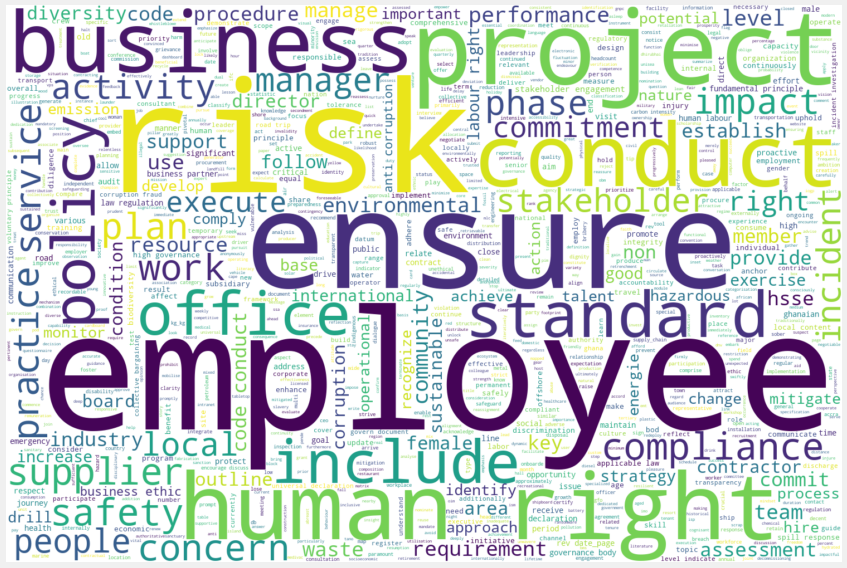

In [24]:
from wordcloud import WordCloud

# aggregate all 7200 records into one large string to run wordcloud on term frequency
large_string = ' '.join(report_sentences_lemma)

# use 3rd party lib to compute term freq., apply stop words
word_cloud = WordCloud(
    background_color="white",
    max_words=5000, 
    width=1500, 
    height=1000, 
    stopwords=combined_stop_words, 
    contour_width=3, 
    contour_color='steelblue'
)

# display our wordcloud across all records
plt.figure(figsize=(16,16))
word_cloud.generate(large_string)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### TFIDF - Unigram and Bigram Analysis

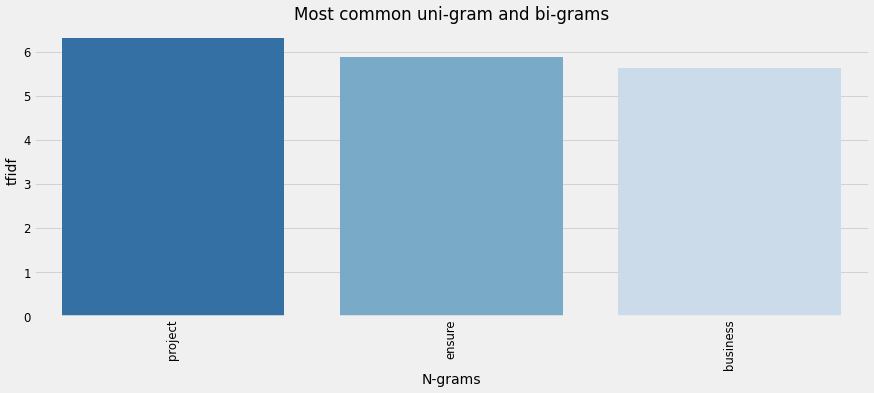

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Run bi-gram TF-IDF frequencies
bigram_tf_idf_vectorizer = TfidfVectorizer(stop_words=combined_stop_words, ngram_range=(1,2), min_df=10, use_idf=True)
bigram_tf_idf = bigram_tf_idf_vectorizer.fit_transform(report_sentences_lemma)

# Extract bi-grams names
words = bigram_tf_idf_vectorizer.get_feature_names_out()

# extract our top 10 ngrams
total_counts = np.zeros(len(words))
for t in bigram_tf_idf:
    total_counts += t.toarray()[0]

count_dict = (zip(words, total_counts))
count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:30]
words = [w[0] for w in count_dict]
counts = [w[1] for w in count_dict]
x_pos = np.arange(len(words)) 

# Plot top ngrams
plt.figure(figsize=(16, 6))
plt.subplot(title='Most common uni-gram and bi-grams')
sns.barplot(x=x_pos, y=counts, palette='Blues_r')
plt.xticks(x_pos, words, rotation=90) 
plt.xlabel('N-grams')
plt.ylabel('tfidf')
plt.show()

---


## Topic Modeling and Latent Dirichlet Allocation (LDA)

Evaluaton Metrics
1. **Perplexity**: Captures how surprised a model is of new data it has not seen before, and is measured as the normalized log-likelihood of a held-out test set.  Lower the better.
2. **Coherence Score**: Measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic.  Higher the better.

In the analysis, the model with the highest coherence score is selected as the optimal model.

In [26]:
# Create Dictionary mapping each word to a unique ID 
Dictionary = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency Convert tokenized corpus into bag-of-words representation
corpus = [Dictionary.doc2bow(text) for text in texts]

In [27]:
corpus[:1]

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 2),
  (4, 1),
  (5, 1),
  (6, 2),
  (7, 1),
  (8, 5),
  (9, 4),
  (10, 4),
  (11, 1),
  (12, 1),
  (13, 2),
  (14, 2),
  (15, 1),
  (16, 1),
  (17, 5),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 3),
  (22, 1),
  (23, 2),
  (24, 2),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 2),
  (29, 2),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 2),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 8),
  (43, 2),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 2),
  (51, 1),
  (52, 7),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 3),
  (58, 1),
  (59, 3),
  (60, 1),
  (61, 1),
  (62, 2),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 9),
  (67, 1),
  (68, 4),
  (69, 3),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 2),
  (74, 1),
  (75, 1),
  (76, 4),
  (77, 2),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 2),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 2),
  (89, 1),
  (90, 1),
  (91, 1)

In [28]:
[[(Dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('accessibility', 1),
  ('act', 1),
  ('activity', 1),
  ('age', 2),
  ('applicable', 1),
  ('approve', 1),
  ('assessment', 2),
  ('assign', 1),
  ('board', 5),
  ('bod', 4),
  ('body', 4),
  ('box', 1),
  ('business', 1),
  ('ceo', 2),
  ('chief', 2),
  ('clear', 1),
  ('climate', 1),
  ('code', 5),
  ('collective', 1),
  ('commit', 1),
  ('committee', 1),
  ('communicate', 3),
  ('communication', 1),
  ('company', 2),
  ('compliance', 2),
  ('composition', 1),
  ('comprehensive', 1),
  ('comprise', 1),
  ('concern', 2),
  ('conduct', 2),
  ('conference', 1),
  ('contract', 1),
  ('contractor', 1),
  ('corruption', 1),
  ('critical', 2),
  ('currently', 1),
  ('date', 1),
  ('detailed', 1),
  ('development', 1),
  ('deviation', 1),
  ('diligence', 1),
  ('direct', 1),
  ('director', 8),
  ('discrimination', 2),
  ('distribute', 1),
  ('diversity', 1),
  ('document', 1),
  ('door', 1),
  ('effectiveness', 1),
  ('employ', 1),
  ('employee', 2),
  ('energie', 1),
  ('energy', 7),
  (

In [29]:
results = []
optimal_score = 0
optimal_model = None
LDA=gensim.models.ldamodel.LdaModel
for num_of_topics in tqdm(range(2,15,1)):
    
    result = {}
    
    # Build LDA model
    lda_model = LDA(corpus=corpus,
                    id2word=Dictionary,
                    num_topics=num_of_topics, 
                    random_state=42,
                    update_every=1,
                    chunksize=5,
                    passes=10,
                    alpha='auto',
                    per_word_topics=True) 

    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=Dictionary, coherence='c_v')
    
    if optimal_score < coherence_model_lda.get_coherence():
        optimal_score = coherence_model_lda.get_coherence()
        optimal_model = lda_model

    result['num_of_topics'] = num_of_topics
    result['perplexity'] = lda_model.log_perplexity(corpus)
    result['coherence_score'] = coherence_model_lda.get_coherence()
    
    results.append(result)
    
results = pd.DataFrame(results)  
results.set_index('num_of_topics', inplace=True) 

  0%|          | 0/13 [00:00<?, ?it/s]

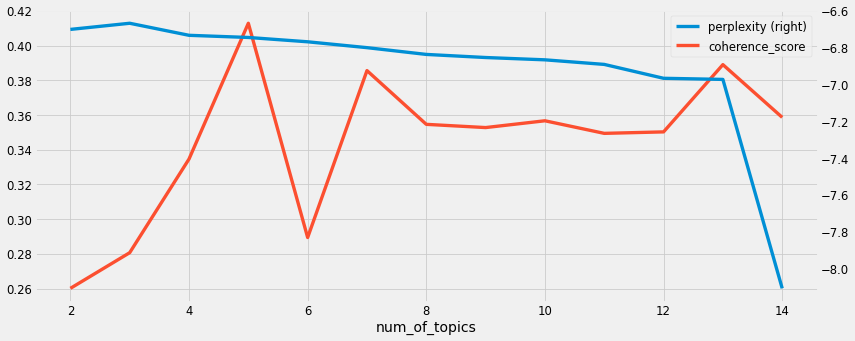

In [30]:
results.plot(secondary_y='perplexity')
plt.show()

In [31]:
results

perplexity  coherence_score
num_of_topics                             
2               -6.702384         0.260183
3               -6.669067         0.280726
4               -6.734399         0.334676
5               -6.746085         0.412866
6               -6.769570         0.289463
7               -6.801363         0.385606
8               -6.838062         0.354651
9               -6.854846         0.352788
10              -6.867377         0.356700
11              -6.892224         0.349453
12              -6.967512         0.350301
13              -6.973576         0.389038
14              -8.106824         0.358666

In [32]:
# Compute Perplexity
print('\nPerplexity of the Optimal Model: ', optimal_model.log_perplexity(corpus))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_lemmatized, dictionary=Dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score of the Optimal Model: ', coherence_lda)


Perplexity of the Optimal Model:  -6.746085355851031

Coherence Score of the Optimal Model:  0.41286577438344596


# Topic  help to inferr the topic name to relate it the esg topic as seeen in the topic 1 which relateds to  
the visulization below shows the topics

A bubble on the left-hand side plot that represents a topic. The larger the bubble, the more prevalent is the topic.


---

## Visualize the topics

In [33]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, Dictionary)
vis.topic_coordinates['x'] = np.real(vis.topic_coordinates['x'])
vis.topic_coordinates['y'] = np.real(vis.topic_coordinates['y'])
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.141566  0.128468       1        1  32.599834
3      0.194968  0.057796       2        1  25.409285
0     -0.070822 -0.094834       3        1  24.791672
2     -0.007739 -0.076064       4        1  13.224882
1      0.025160 -0.015366       5        1   3.974326, topic_info=            Term       Freq      Total Category  logprob  loglift
254         risk  29.000000  29.000000  Default  30.0000  30.0000
701      execute  14.000000  14.000000  Default  29.0000  29.0000
352      service  17.000000  17.000000  Default  28.0000  28.0000
864        waste  13.000000  13.000000  Default  27.0000  27.0000
350       safety  15.000000  15.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
137        skill   0.576888   2.816655   Topic5  -5.3523   1.6397
652         goal   0.643189   4.245703   Topic5  -5.2435   1.3381
332  performance   0.578972   9.739308   Topic5  -5.3487   0.4026
273         work   0.564980   9.679461   Topic5  -5.3731   0.3843
121      process   0.465936   5.063650   Topic5  -5.5659   0.8395

[276 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
811       2  0.935504      accra
159       3  0.744010    achieve
159       5  0.248003    achieve
277       3  0.476188   actively
277       5  0.476188   actively
...     ...       ...        ...
273       5  0.103312       work
626       4  0.933861  workforce
158       1  0.095818       year
158       2  0.287454       year
158       4  0.574908       year

[323 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 1, 3, 2])

In [34]:
optimal_model.show_topics(formatted=True)

[(0,
  '0.020*"service" + 0.020*"right" + 0.019*"employee" + 0.018*"energy" + 0.018*"business" + 0.015*"pecan" + 0.014*"standard" + 0.014*"conduct" + 0.013*"corruption" + 0.013*"human"'),
 (1,
  '0.014*"target" + 0.014*"diversity" + 0.012*"equal" + 0.009*"develop" + 0.009*"talent" + 0.009*"make" + 0.008*"achieve" + 0.006*"attract" + 0.006*"employer" + 0.006*"retain"'),
 (2,
  '0.018*"energy" + 0.016*"year" + 0.015*"employee" + 0.013*"female" + 0.011*"governance" + 0.011*"report" + 0.010*"director" + 0.010*"hire" + 0.009*"pecan" + 0.009*"include"'),
 (3,
  '0.031*"energy" + 0.018*"execute" + 0.016*"waste" + 0.016*"oil" + 0.015*"office" + 0.015*"operation" + 0.013*"fpso" + 0.013*"spill" + 0.011*"exercise" + 0.011*"pecan"'),
 (4,
  '0.028*"risk" + 0.017*"energy" + 0.016*"incident" + 0.015*"management" + 0.015*"safety" + 0.015*"level" + 0.013*"ensure" + 0.012*"road" + 0.010*"stakeholder" + 0.009*"conduct"')]

---

## Distinguishing the different ESG topics

In [35]:
topic_names = {
    0: 'business ethics',
    1: 'employee value',
#     2: 'climate change action',
#     3: 'sustainable resource use',
#     4: 'clean energy adoption',
#     5: 'carbon footprint reduction',
#     6: 'water conservation',
#     7: 'waste management',
#     8: 'ethical sourcing',
#     9: 'employee diversity and inclusion',
#     10: 'labor rights protection',
#     11: 'workplace safety',
#     12: 'employee well-being',
#     13: 'education and skill development',
#     14: 'human rights protection',
#     15: 'fair trade practices',
#     16: 'data privacy and security',
#     17: 'board diversity',
#     18: 'executive compensation',
#     19: 'transparency and accountability',
#     20: 'anti-corruption measures',
#     21: 'tax transparency',
#     22: 'product safety',
#     23: 'supply chain transparency',
#     24: 'community engagement'
#     25: 'stakeholder social licence'
}


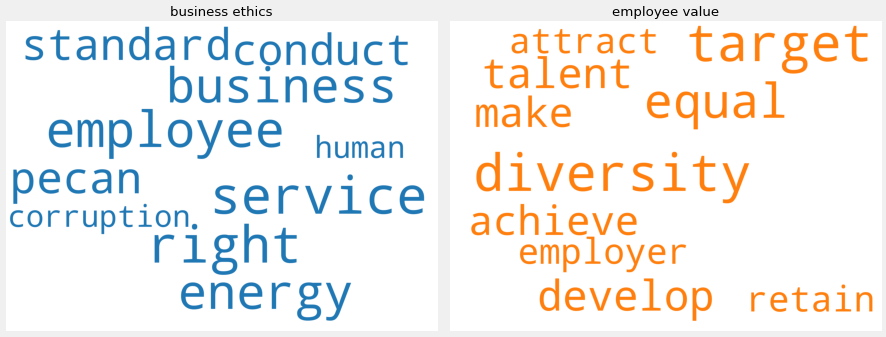

In [36]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=50,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 2, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(topic_names[i], fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## ESG Classification of senetences and visualization of number sentences per ESG dimension

In [37]:

# pipeesg = pipeline("text-classification", model="cea-list-lasti/ESG-classification-en",device=0)
environment_model_name = "ESGBERT/EnvironmentalBERT-environmental"
model=AutoModelForSequenceClassification.from_pretrained(environment_model_name).to(device)
tokenizer=AutoTokenizer.from_pretrained(environment_model_name)
pipeenvironment=pipeline("text-classification",model=model,tokenizer=tokenizer,device=0)

social_model_name = "ESGBERT/SocialBERT-social"
model=AutoModelForSequenceClassification.from_pretrained(social_model_name).to(device)
tokenizer=AutoTokenizer.from_pretrained(social_model_name)
pipesocial=pipeline("text-classification",model=model,tokenizer=tokenizer)

gorvenance_model_name = "ESGBERT/GovernanceBERT-governance"
model=AutoModelForSequenceClassification.from_pretrained(gorvenance_model_name).to(device)
tokenizer=AutoTokenizer.from_pretrained(gorvenance_model_name)
pipegorvenance=pipeline("text-classification",model=model,tokenizer=tokenizer,device=0)

sentences_df=pd.DataFrame({'Sentences':report_sentences})
sentences_df.head(5)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Sentences
0  We have requirements for human and labour righ...
1  We have zero tolerance for corruption and prom...
2  We perform human rights impact assessment and ...
3  The managers are positioned throughout the org...
4  As an illustration, the key governing document...

In [38]:
def esg_sentences_classification(sentences_df):
    txt = sentences_df["Sentences"].copy().to_list()
    
    environment_classification=pipeenvironment(txt,padding=True, truncation=True, batch_size=16)
    environment_labels_only = [x["label"] for x in environment_classification]

    social_classification=pipesocial(txt,padding=True, truncation=True, batch_size=16)
    social_labels_only = [x["label"] for x in social_classification]

    governance_classification=pipegorvenance(txt,padding=True, truncation=True, batch_size=16)
    governance_labels_only = [x["label"] for x in governance_classification]

    df = pd.DataFrame({"Sentences": txt, "environmental": environment_labels_only, "social ": social_labels_only,"governance": governance_labels_only})
    return df

In [39]:
esg_df=esg_sentences_classification(sentences_df)
esg_df

Sentences environmental social   governance
0    We have requirements for human and labour righ...          none  social        none
1    We have zero tolerance for corruption and prom...          none  social  governance
2    We perform human rights impact assessment and ...          none  social        none
3    The managers are positioned throughout the org...          none    none        none
4    As an illustration, the key governing document...          none    none  governance
..                                                 ...           ...     ...         ...
199  The following are key safety tips to adopt whe...          none    none        none
200  Safety Tips: Schedule your journey carefully t...          none    none        none
201  Consider road hazards and weather conditions; ...          none    none        none
202  Plan when and where to take rests based on the...          none    none        none
203  It is advised for employees to go with enough ...          none    none        none

[204 rows x 4 columns]

In [40]:
environmental_counts,social_counts,governance_counts = esg_df['environmental'].value_counts(dropna=False),esg_df['social '].value_counts(dropna=False),esg_df['governance'].value_counts(dropna=False)
print(environmental_counts)
print()
print(social_counts)
print()
print(governance_counts)

environmental
none             164
environmental     40
Name: count, dtype: int64

social 
none      123
social     81
Name: count, dtype: int64

governance
none          174
governance     30
Name: count, dtype: int64


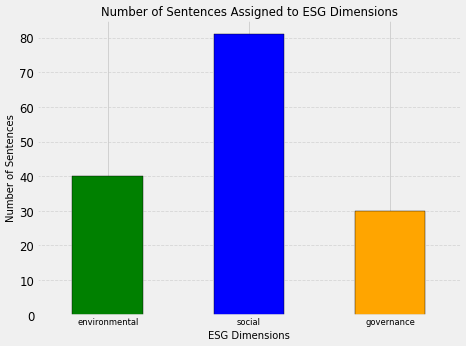

In [41]:
# esg_df.replace("none", pd.NA, inplace=True)

# Count occurrences of ESG sentences
esg_counts = esg_df.apply(pd.Series.value_counts).sum(axis=1)

# Filter only relevant ESG categories
esg_counts = esg_counts[["environmental", "social", "governance"]]

# Plot the bar chart
plt.figure(figsize=(8, 6))
esg_counts.plot(kind='bar', color=['green', 'blue', 'orange'], edgecolor='black')

# Customize the chart
plt.title("Number of Sentences Assigned to ESG Dimensions", fontsize=14)
plt.xlabel("ESG Dimensions", fontsize=12)
plt.ylabel("Number of Sentences", fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()
# Show interactive plot
plt.show()

The Pecan 2023 energies report had the social aspect of the ESG dimension as its strongest of the 3 esg dimension and governnace as the lest prominent indicating the companies inclination to social and commnity impact project as seen across the report.